In [6]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold
import  matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

import gc
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [52]:
# 常量定义
NFOLDS = 5  # 交叉验证的折数
SEQ_LEN = 5  # 序列长度
WINDOW_SIZE = 2 * SEQ_LEN  # 窗口长度
MODEL_N = 10  # 10个模型分别预测 CPU_USAGE_6...LAUNCHING_JOB_NUMS_10

__author__ = 'siliconx'
__version__ = '1.0.0'

pd.options.display.max_columns = None  # 展示所有列

In [69]:
# 初始数据
RAW_TRAIN = '../data/train.csv'
RAW_TEST = '../data/evaluation_public.csv'
SAMPLE_SUBMIT = '../data/submit_example.csv'
# 加载原始数据
train_df = pd.read_csv(RAW_TRAIN)
test_df = pd.read_csv(RAW_TEST)
# sample_df = pd.read_csv(SAMPLE_SUBMIT)

train_df = train_df.sort_values(by=['QUEUE_ID', 'DOTTING_TIME']).reset_index(drop=True)
test_df = test_df.sort_values(by=['ID', 'DOTTING_TIME']).reset_index(drop=True)
train_df['DOTTING_TIME']  = pd.to_datetime(train_df['DOTTING_TIME'], unit='ms')
test_df['DOTTING_TIME']  = pd.to_datetime(test_df['DOTTING_TIME'], unit='ms')


In [137]:
# train_df[['QUEUE_ID','CU']].drop_duplicates(['QUEUE_ID','CU']).sort_values('CU')

In [138]:
t = train_df
# .QUEUE_ID.unique() &(train_df['QUEUE_TYPE']=='general')
# t.groupby('QUEUE_ID')['CPU_USAGE'].mean().sort_values(ascending=True)

In [139]:
# t.groupby('QUEUE_ID')['CPU_USAGE'].std().sort_values(ascending=False)

In [140]:
# 
# test_df[test_df['QUEUE_ID']==297].head(50)
# t = test_df[test_df['QUEUE_ID']==85153]
# t[t['CPU_USAGE']==0]
# len(t)/5
# t.head()

In [82]:
train_df['month']  = train_df['DOTTING_TIME'].dt.month
test_df['month']  = test_df['DOTTING_TIME'].dt.month

train_df['year']  = train_df['DOTTING_TIME'].dt.year
test_df['year']  = test_df['DOTTING_TIME'].dt.year


In [55]:
train_df.groupby('QUEUE_ID')['DOTTING_TIME'].count().sort_values(ascending=False)

QUEUE_ID
21487    28931
21671    28095
297      21184
298      20381
81221    19781
21673    19726
82695    19726
21825    19723
4        19257
3        19257
2        19255
84387    17520
85153    14353
20889    14005
85265    13516
85267    13082
84151    11857
85693    10834
82697    10642
27       10526
26       10407
281      10365
82929    10199
85619     9997
85915     9220
83109     8958
291       8884
293       8855
85933     8811
85977     8793
85731     8568
287       6876
85101     6618
84907     6495
86085     6195
86867     3753
86865     3544
36        3242
85617     2553
87139     2378
83609     2120
233       2099
85781     1149
Name: DOTTING_TIME, dtype: int64

id <built-in function id> month 2 162


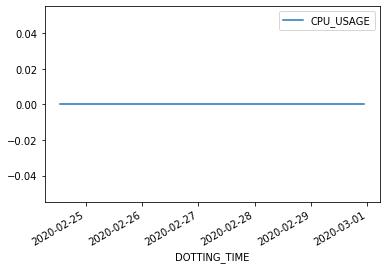

id <built-in function id> month 3 1304


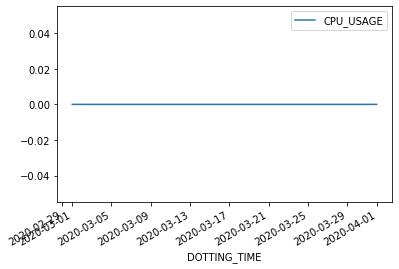

id <built-in function id> month 4 1473


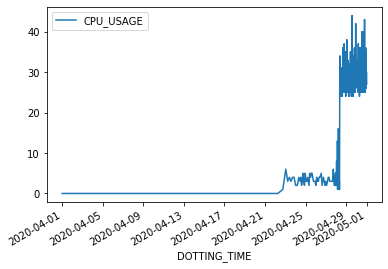

id <built-in function id> month 5 7271


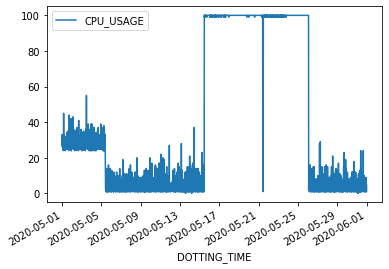

id <built-in function id> month 6 6588


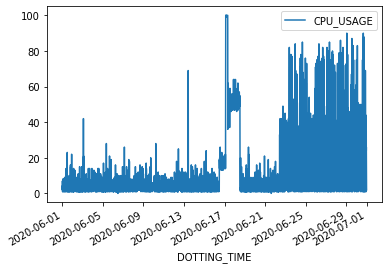

id <built-in function id> month 7 4386


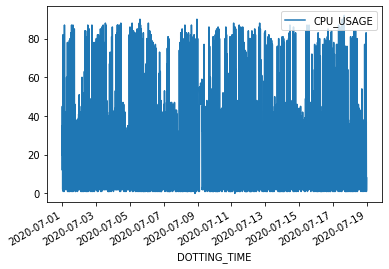

In [56]:
tmp = train_df[train_df['QUEUE_ID']==297]
for i in tmp['month'].unique():
    plot_cpu = tmp[['CPU_USAGE','DOTTING_TIME']].copy()
    _plot_cpu = plot_cpu[plot_cpu['DOTTING_TIME'].dt.month==i]
    _plot_cpu.set_index('DOTTING_TIME',inplace=True)
    print('id',id,'month',i,len(_plot_cpu))
    _plot_cpu.plot()
    plt.show()

id <built-in function id> month 9 560


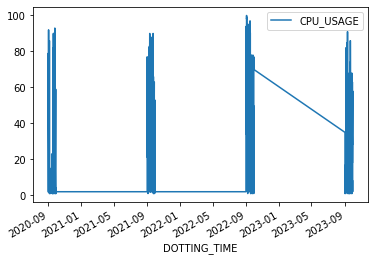

id <built-in function id> month 6 430


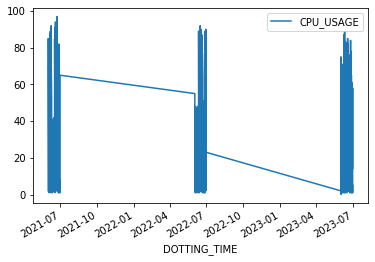

id <built-in function id> month 10 590


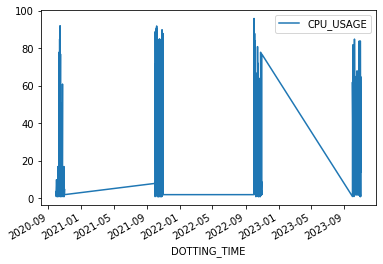

id <built-in function id> month 8 590


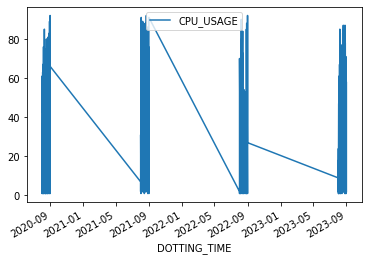

id <built-in function id> month 3 450


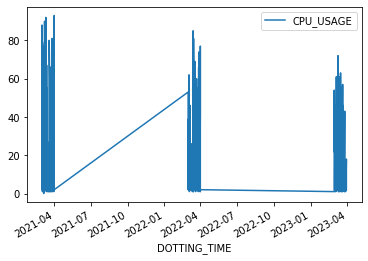

id <built-in function id> month 2 390


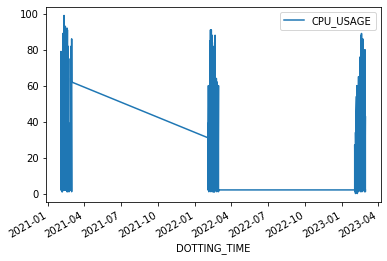

id <built-in function id> month 4 425


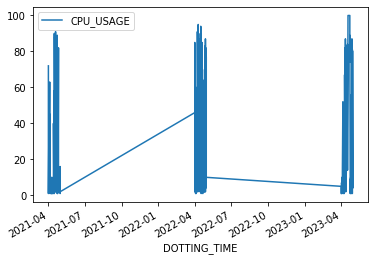

id <built-in function id> month 7 505


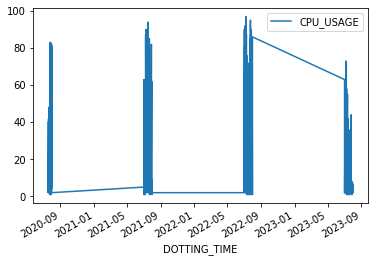

id <built-in function id> month 1 445


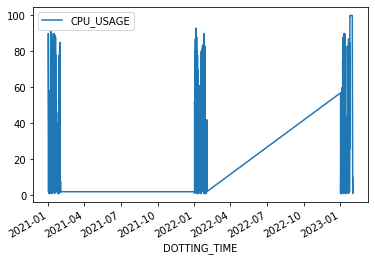

id <built-in function id> month 11 450


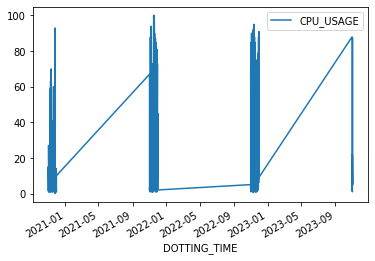

id <built-in function id> month 12 435


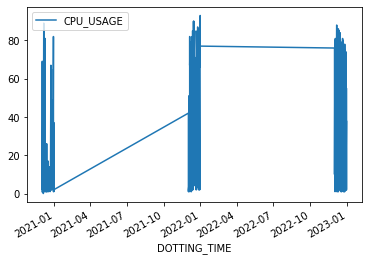

id <built-in function id> month 5 440


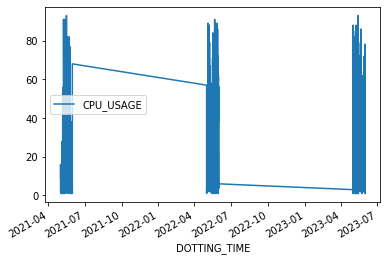

In [86]:
tmp = test_df[test_df['QUEUE_ID']==297]
for i in tmp['month'].unique():
    plot_cpu = tmp[['CPU_USAGE','DOTTING_TIME']].copy()
    _plot_cpu = plot_cpu[plot_cpu['DOTTING_TIME'].dt.month==i]
    _plot_cpu.set_index('DOTTING_TIME',inplace=True)
    print('id',id,'month',i,len(_plot_cpu))
    _plot_cpu.plot()
    plt.show()

5710 1142.0
id <built-in function id> year 2022 1730


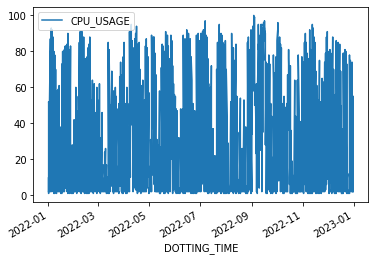

id <built-in function id> year 2021 1740


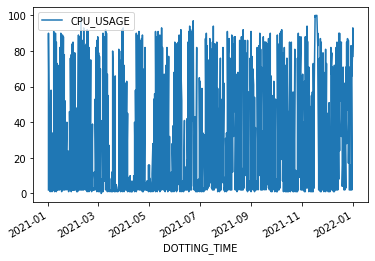

id <built-in function id> year 2023 1450


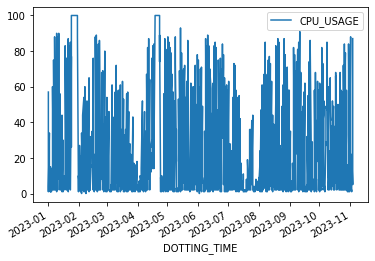

id <built-in function id> year 2020 790


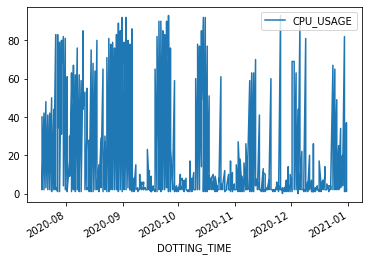

In [87]:
tmp = test_df[test_df['QUEUE_ID']==297]
print(len(tmp),len(tmp)/5)
for i in tmp['year'].unique():
    plot_cpu = tmp[['CPU_USAGE','DOTTING_TIME']].copy()
    _plot_cpu = plot_cpu[plot_cpu['DOTTING_TIME'].dt.year==i]
    _plot_cpu.set_index('DOTTING_TIME',inplace=True)
    print('id',id,'year',i,len(_plot_cpu))
    _plot_cpu.plot()
    plt.show()

In [57]:
qid297 =  train_df[train_df['QUEUE_ID']==297]
qid297['delta_time'] = qid297['DOTTING_TIME'].diff().astype('timedelta64[m]')

In [59]:
qid297.loc[qid297['delta_time']<=20,'sess'] = 1
qid297.loc[qid297['delta_time']>20,'sess'] = 0

In [104]:
_qid297 = qid297[qid297.month == 4][['CPU_USAGE','MEM_USAGE','RUNNING_JOB_NUMS','LAUNCHING_JOB_NUMS','DOTTING_TIME','delta_time','sess']]

In [110]:
# _qid297[_qid297['sess']==0].iloc[0:400].tail(50)

In [111]:
# qid297[['CPU_USAGE','MEM_USAGE','RUNNING_JOB_NUMS','LAUNCHING_JOB_NUMS','DOTTING_TIME','delta_time','sess']].iloc[3000:5050]